# References

In [78]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../../fastai/old/') #fastai version 0.7
#sys.path.append('../../fastai/') #fastai version 1

from fastai.conv_learner import *
from fastai.dataset import *
import torchvision.models as pytorch_models

import pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
from pathlib import Path
from glob import glob
from matplotlib.patches import Rectangle
import png
from tqdm import tqdm_notebook as tqdm

In [79]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

# Global Variables

In [80]:
dp = Path('../../datasets/RSNA_PDC/')

DICOMS = dp/'stage_2_train_images'

PNGS = dp/'train2_png'
PNGS.mkdir(exist_ok=True)

#TEST_ONE = 'test1_png'
TEST_ONE = 'BLÖDSINN DAMITS AUFFÄLLT'
TEST_TWO = 'test2_png'

SUBMISSIONS = dp/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

#f_model=resnet34
f_model = pytorch_models.inception_v3(pretrained=True)

sz=1024
bs=32

validation_percentage = 0.05

# Useful functions 

In [11]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax

def from_dicom_to_png(dicom_path, png_path):
    ds = pydicom.dcmread(dicom_path)
    shape = ds.pixel_array.shape
    # Convert to float to avoid overflow or underflow losses.
    image_2d = ds.pixel_array.astype(float)
    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max()) * 255.0
    # Convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)
    # Write the PNG file
    with open(png_path, 'wb') as png_file:
        w = png.Writer(shape[1], shape[0], greyscale=True)
        w.write(png_file, image_2d_scaled)
        
        
def hw_bb(row): return np.array([row['y'], row['x'], row['height']+row['y'], row['width']+row['x']])

##[x_upper_left, y_upper_left, width, height]
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    parsed = collections.defaultdict(lambda:{'dicom': None,
                                        'png': None,     
                                        'label': None,
                                        'boxes': []})
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        parsed[pid]['dicom'] = str(DICOMS/f'{pid}.dcm')
        parsed[pid]['png'] = str(PNGS/f'{pid}.png')
        parsed[pid]['label'] = row['Target']
        parsed[pid]['boxes'].append(hw_bb(row))

    return parsed

def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[-2:]-x[:2]), reverse=True)
    return [b[0]]

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap='gray')
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, col='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=col, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, col='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=col, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann, ax=None):
    ax = show_img(im, figsize=(12,6), ax=ax)
    l = cats[ann['label']]
    for b in ann['boxes']:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], l, sz=16)
        
def draw_idx(im_a, ax=None):
    dcm_data = pydicom.read_file(im_a['dicom'])
    im = dcm_data.pixel_array
    draw_im(im, im_a, ax=ax)
    
def from_dicom_to_png(parsed):
    for k, v in parsed.items():
        dcm_data = pydicom.read_file(v['dicom'])
        im = dcm_data.pixel_array
        imageio.imwrite(v['png'], im)
        
class ObjDetDataset(Dataset):
    def __init__(self, ds, y2): 
        self.ds = ds 
        self.y2 = y2
    
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

# Data Exploration

## Paths 

In [ ]:
list(dp.iterdir())

In [ ]:
s1_dci, s1_ssub, s1_tls, images = ['stage_2_detailed_class_info.csv', 'stage_2_sample_submission.csv', 'stage_2_train_labels.csv', 'stage_2_train_images']

## Detailed class info csv file

In [ ]:
dci_df = pd.read_csv(dp/s1_dci)
print(dci_df.shape[0])
dci_df[:5]

In [ ]:
dci_df.groupby('class').size().plot.bar()

## Bounding boxes csv file

In [ ]:
bbox_df = pd.read_csv(dp/s1_tls)
bbox_df[:5]

In [ ]:
bbox_df.groupby('Target').size().plot.bar()

## Combine boxes and labels 

In [ ]:
comb_bbox_df = pd.concat([bbox_df, 
                        dci_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df[:5]

## Distribution of boxes per patient

In [ ]:
box_df = comb_bbox_df.groupby('patientId')['x'].count().reset_index(name='boxes')
box_df
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.groupby('boxes').size().reset_index(name='patients')

## Relation of class and target

In [ ]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

##  Images

### Image ids 

In [ ]:
image_df = pd.DataFrame({'path' : glob(os.path.join(dp/images, '*.dcm'))})
image_df['patientId'] = image_df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
image_df

In [ ]:
print(image_df.shape[0], 'images found')

In [ ]:
img_pat_ids = set(image_df['patientId'])
box_pat_ids = set(comb_box_df['patientId'])
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

### DICOM headers and full final dataframe with all information about an image

In [ ]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)

In [ ]:
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [ ]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')
image_bbox_df = pd.merge(comb_box_df, 
                         image_full_df, 
                         on='patientId',
                        how='left')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df

### Create Sample Data Set

In [ ]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df

### Show the position and bounding box

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()

### Bounding Box Distribution 

In [ ]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

### Show the boxes as segmentation

In [ ]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

### Overlay the Probability on a few images

In [ ]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
#fig.savefig('overview.png', figdpi = 600)

### Save the preprocessed results

In [ ]:
image_bbox_df.to_csv(dp/'image_bbox_full.csv', index=False)

# Classifier opacity, no opacity

## Add new coloumn: opacity/no opacity

In [ ]:
image_bbox_df = pd.read_csv(dp/'image_bbox_full.csv')
image_bbox_df

In [ ]:
targets = image_bbox_df['Target']
targets

In [ ]:
classes = []
for n, t in tqdm(enumerate(targets), total=len(targets)):
    if t == 0:
        classes.append('no_opacity')
    else:
        classes.append('opacity')

In [ ]:
classes

In [ ]:
image_bbox_df['opacity/no opacity'] = classes

In [ ]:
image_bbox_df

## Convert .dcm to .png

### Add coloumn with paths for .png images

In [ ]:
image_bbox_df

In [ ]:
patientIds = image_bbox_df['patientId']
png_paths = []
for i in patientIds:
    n = i+'.png'
    png_paths.append(PNGS/n)

image_bbox_df['png_path'] = png_paths
image_bbox_df

### Create a distinct list of patient ids

In [ ]:
image_bbox_df_distinct = image_bbox_df.drop_duplicates(subset='path', keep='first')
image_bbox_df_distinct

### Save/read dfs as/from csv

In [ ]:
image_bbox_full_csv_name = 'image_bbox_full.csv'
image_bbox_distinct_full_csv_name = 'image_bbox_distinct_full.csv'

In [ ]:
image_bbox_df.to_csv(dp/image_bbox_full_csv_name, index=False)
image_bbox_df_distinct.to_csv(dp/image_bbox_distinct_full_csv_name, index=False)

In [ ]:
image_bbox_df = pd.read_csv(dp/image_bbox_full_csv_name)
image_bbox_df_distinct = pd.read_csv(dp/image_bbox_distinct_full_csv_name)

### Converting

In [ ]:
for index, row in tqdm(image_bbox_df_distinct.iterrows(), total=image_bbox_df_distinct.shape[0]):
    if not os.path.isfile(row['png_path']):
        from_dicom_to_png(row['path'], row['png_path'])

len(list(PNGS.iterdir()))

In [ ]:
img = open_image(image_bbox_df_distinct['png_path'][0])
show_img(img)

## Build and train model

In [ ]:
df = pd.DataFrame({'fn': image_bbox_df_distinct['patientId']+'.png', 'cat' : image_bbox_df['opacity/no opacity']})
df = df.dropna()
df = df.reset_index()
df = df.drop(df.columns[[0]], axis=1)
df

In [ ]:
(dp/'tmp').mkdir(exist_ok=True)
CSV = dp/'tmp/class.csv'
df.to_csv(CSV, index=False)

In [ ]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), CSV, tfms=tfms, bs=bs)

In [ ]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [ ]:
learn.get_activations

In [ ]:
lrf=learn.lr_find(1e-5,100)

In [ ]:
learn.sched.plot()

In [ ]:
lr = 2e-3

In [ ]:
learn.fit(lr, 1, cycle_len=1)

In [ ]:
lrs = np.array([lr/1000,lr/100,lr])

In [ ]:
learn.freeze_to(-2)

In [ ]:
lrf=learn.lr_find(lrs/10000)
learn.sched.plot(1)

In [ ]:
learn.fit(lrs/5, 1, cycle_len=1)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs/5, 1, cycle_len=2)

In [ ]:
learn.save('opacity-no_opacity-classifier')

In [ ]:
learn.load('opacity-no_opacity-classifier')

In [ ]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

In [ ]:
y

In [ ]:
y_np = to_np(y)
y_np

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), f'pred:{b}, targ: {y_np[i]}')
plt.tight_layout()

# Largest pneumonia focus detector

## dataframe and csv preparation

In [ ]:
labs = pd.read_csv(dp/'stage_1_train_labels.csv')
labs.head()

In [ ]:
labs.x.fillna(0, inplace=True)
labs.y.fillna(0, inplace=True)
labs.width.fillna(1023, inplace=True)
labs.height.fillna(1023, inplace=True)

labs.head()

In [ ]:
parsed = parse_data(labs)

parsed_lrg = {a: {'dicom': b['dicom'],
                  'png': b['png'],
                  'label': b['label'],
                  'boxes': get_lrg(b['boxes'])} for a, b in parsed.items()}

In [ ]:
cats = {0: 'normal', 1: 'pneumonia'}

In [ ]:
patient = '3b081d12-6804-4a33-85cd-712a886e4e01'
parsed[patient]

In [ ]:
parsed_lrg[patient]

In [ ]:
bb = parsed_lrg[patient]['boxes'][0]
bb_transformed = bb_hw(bb)
bb_original = labs.loc[labs.patientId == patient,:].iloc[1]

print(f'Top-Left-Bottom-Right BB: {bb}')
print(f'Transformed Top-Left-WH: {bb_transformed}')
print(f'Original Top-Left-WH: [{bb_original.x} {bb_original.y} {bb_original.width} {bb_original.height}]')

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    patient = labs.patientId.sample().values[0]
    draw_idx(parsed_lrg[patient], ax=ax)

plt.tight_layout()

In [ ]:
(dp/'tmp').mkdir(exist_ok=True)

CSV = dp/'tmp/class.csv'
BB_CSV = dp/'tmp/bb.csv'

In [ ]:
df_lrg = pd.DataFrame({'fn': [parsed_lrg[o]['png'] for o in parsed_lrg],
                   'cat': [parsed_lrg[o]['label'] for o in parsed_lrg],
                   'bbox': [' '.join(str(p) for p in parsed_lrg[o]['boxes'][0]) for o in parsed_lrg]})

In [ ]:
df_lrg.head()

In [ ]:
df_lrg.cat.sum()/df_lrg.shape[0]

In [ ]:
li = [str(el) for el in list((PNGS).iterdir())]
len(li)

In [ ]:
dfs = df_lrg.loc[df_lrg.fn.isin(li),:]
dfs.shape

In [ ]:
dfs.head()

In [ ]:
filePaths = dfs['fn']
fns = []
for f in filePaths:
    fns.append(os.path.basename(f))
    
dfs['fn'] = fns


In [ ]:
dfs.head()

In [ ]:
dfs.cat.sum()/dfs.shape[0]

In [ ]:
dfs[['fn', 'bbox']].to_csv(BB_CSV, index=False)

In [ ]:
dfs[['fn', 'bbox']].head()

## Largest opacity detection modeling pipeline

### Figuring out input dimension of custom head to stack on top of CNN

In [ ]:
cl_df = pd.read_csv(CSV)
cl_df.head()

In [ ]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), CSV, tfms=tfms, bs=bs)
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

learn.summary()

The output dimension of the last Conv Block (BasicBlock-122) is [-1, 512, 16, 16].
We will make use of the very handy head concept within the fast.ai library 
which allows to truncate the pre-trained network to its last conv layer and stack a custom model on top.
The input shape of the custom head will be 512 * 16 * 16 = 131072

In [ ]:
input_to_top_model = 512 * 16 * 16

### Combinig boxes and classes in one dataset

In [ ]:
dfs.head()

In [ ]:
val_idxs = get_cv_idxs(len(dfs))

In [ ]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [ ]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [ ]:
md_box = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), BB_CSV, tfms=tfms, bs=bs, continuous=True, val_idxs=val_idxs)

In [ ]:
md_class = ImageClassifierData.from_csv(dp, os.path.basename(PNGS), CSV, tfms=tfms_from_model(f_model, sz), bs=bs)

In [ ]:
trn_ds = ObjDetDataset(md_box.trn_ds, md_class.trn_y)
val_ds = ObjDetDataset(md_box.val_ds, md_class.val_y)

In [ ]:
trn_ds[0][1]

In [ ]:
md_box.trn_dl.dataset = trn_ds
md_box.val_dl.dataset = val_ds

In [ ]:
x,y=next(iter(md_box.val_dl))

In [ ]:
idx=3
ima=md_box.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])) 
b

In [ ]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md_box.classes[y[1][idx]])

### Check augmented data

In [ ]:
idx = 4
fig,axes = plt.subplots(3,3, figsize=(12,12))
for i,ax in enumerate(axes.flat):
    x, y= next(iter(md_box.aug_dl))
    ima = md_box.val_ds.ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    show_img(ima, ax=ax)
    draw_rect(ax, b)

### Custom head

In [ ]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(input_to_top_model,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md_box, models)
learn.opt_fn = optim.Adam

### How much do we need to multiply the cross_entropy to make it comparable to the f1_loss?

In [ ]:
ratios = []

for i in range(200):
    x, y = next(iter(md_box.trn_dl))
    t = learn.model(V(x))
    
    bb_t,c_t = y
    bb_i,c_i = t[:, :4], t[:, 4:]
    bb_i = torch.sigmoid(bb_i)*sz
    
    reg = F.l1_loss(bb_i, V(bb_t)).data.cpu().numpy()
    clas = F.cross_entropy(c_i, V(c_t)).data.cpu().numpy()
    
    print(reg/clas)
    ratios.append(reg/clas)

In [ ]:
np.mean(ratios)

In [ ]:
np.median(ratios)

In [ ]:
scaler = int(np.mean(ratios))

In [ ]:
scaler

### Loss function

In [ ]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = torch.sigmoid(bb_i)*sz
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*scaler

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = torch.sigmoid(bb_i)*sz
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

### Train

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 2e-4

In [ ]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

In [ ]:
lrs = np.array([lr/100, lr/10, lr])

In [ ]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [ ]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.sched.plot_lr()

### Looking at the results

In [ ]:
y = learn.predict()

In [ ]:
idx = np.random.randint(low=0, high=(len(md_box.val_ds)-1), size=16)

In [ ]:
names = md_box.val_ds.ds.fnames[idx]
true_label = [cats[i] for i in md_box.val_ds.y2[idx]]
true_box = md_box.val_ds.ds.y[idx]

pred_label = [cats[i] for i in np.argmax(y[idx, 4:], axis=1)]
pred_box = (expit(y[idx, :4])*1024).astype(int)

In [ ]:
fig,axes = plt.subplots(4,4, figsize=(16,16))

for i,ax in enumerate(axes.flat):
    im = imageio.imread(names[i])
    ax = show_img(im, ax=ax)
    draw_rect(ax, true_box[i])
    draw_rect(ax, pred_box[i], col='blue')
    draw_text(ax, true_box[i][:2], true_label[i])
    draw_text(ax, pred_box[i][:2]+np.array([0,60]), pred_label[i], col='blue')
    
fig.suptitle('16 Random Validation Images (WHITE = Actual; BLUE = Predicted)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Multiple pneumonia focus detector (ssd)

## Set up data

In [33]:
CLAS_CSV = dp/'tmp/class.csv'
MBB_CSV = dp/'tmp/mbb.csv'

In [34]:
labs2 = pd.read_csv(dp/'stage_2_train_labels.csv')

In [35]:
labs2.x.fillna(0, inplace=True)
labs2.y.fillna(0, inplace=True)
labs2.width.fillna(1023, inplace=True)
labs2.height.fillna(1023, inplace=True)

In [36]:
parsed = parse_data(labs2)

In [37]:
patient = '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
parsed[patient]

{'dicom': '../../datasets/RSNA_PDC/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 'png': '../../datasets/RSNA_PDC/train2_png/0004cfab-14fd-4e49-80ba-63a80b6bddd6.png',
 'label': 0,
 'boxes': [array([   0.,    0., 1023., 1023.])]}

In [38]:
df_cat_bbxs = pd.DataFrame({'fn': [os.path.basename(parsed[o]['png']) for o in parsed],
                   'cat': [parsed[o]['label'] for o in parsed],
                   'bbox': [' '.join(str(int(p)) for p in [val for sublist in parsed[o]['boxes'] for val in sublist]) for o in parsed]})

In [39]:
df_bbxs = df_cat_bbxs[['fn', 'bbox']]

In [40]:
df_bbxs.to_csv(MBB_CSV, index=False)

In [41]:
cats = {0: 'normal', 1: 'pneumonia'}
mc = []
for index, row in tqdm(df_cat_bbxs.iterrows(), total=df_cat_bbxs.shape[0]):
    if row['cat']==0:
        mc.append([cats[0]])
    else:
        boxes = np.array([int(i) for i in row['bbox'].split()])
        n_o_bbxs = np.array([bb_hw(o) for o in boxes.reshape(-1,4)]).shape[0]
        c = []
        for i in range(n_o_bbxs):
            c.append(cats[1]) 
        mc.append(c)
        
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}

In [42]:
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])

In [43]:
mcs[0:10]

array([array([0]), array([0]), array([0]), array([0]), array([1, 1]), array([0]), array([0]), array([1, 1]),
       array([0]), array([0])], dtype=object)

In [46]:
val_idxs = get_cv_idxs(len(df_bbxs), val_pct=validation_percentage)
#val_idxs = []
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [47]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md_mbb_csv = ImageClassifierData.from_csv(dp, 
                                          os.path.basename(PNGS), 
                                          MBB_CSV, 
                                          tfms=tfms, 
                                          bs=bs, 
                                          continuous=True, 
                                          num_workers=4,
                                          test_name=TEST_TWO,
                                          val_idxs=val_idxs)

In [48]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [49]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, col=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, col=colr_list[i%num_colr])

In [50]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [51]:
trn_ds2 = ConcatLblDataset(md_mbb_csv.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md_mbb_csv.val_ds, val_mcs)
md_mbb_csv.trn_dl.dataset = trn_ds2
md_mbb_csv.val_dl.dataset = val_ds2

In [52]:
md_mbb_csv.trn_ds.ds.n

25350

In [53]:
md_mbb_csv.val_ds.ds.n

1334

In [54]:
len(val_idxs)

1334

In [ ]:
#x,y=to_np(next(iter(md_mbb_csv.trn_dl)))
#x=md_mbb_csv.trn_ds.ds.denorm(x)

In [ ]:
x,y=to_np(md_mbb_csv.trn_ds[0:12])
x=md_mbb_csv.trn_ds.ds.denorm(x)

In [ ]:
y[0][3]

In [ ]:
y[0][4]

In [ ]:
y[1][3]

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Bbox per cell

### Set up model

In [55]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [56]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

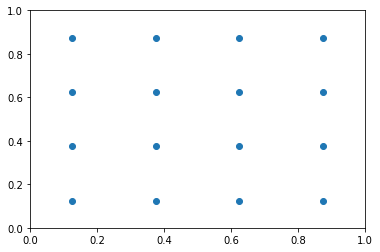

In [57]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [58]:
anchors

tensor([[0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.8750, 0.2500, 0.2500],
        [0.3750, 0.1250, 0.2500, 0.2500],
        [0.3750, 0.3750, 0.2500, 0.2500],
        [0.3750, 0.6250, 0.2500, 0.2500],
        [0.3750, 0.8750, 0.2500, 0.2500],
        [0.6250, 0.1250, 0.2500, 0.2500],
        [0.6250, 0.3750, 0.2500, 0.2500],
        [0.6250, 0.6250, 0.2500, 0.2500],
        [0.6250, 0.8750, 0.2500, 0.2500],
        [0.8750, 0.1250, 0.2500, 0.2500],
        [0.8750, 0.3750, 0.2500, 0.2500],
        [0.8750, 0.6250, 0.2500, 0.2500],
        [0.8750, 0.8750, 0.2500, 0.2500]], device='cuda:0')

In [59]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [60]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[0.0000, 0.0000, 0.2500, 0.2500],
        [0.0000, 0.2500, 0.2500, 0.5000],
        [0.0000, 0.5000, 0.2500, 0.7500],
        [0.0000, 0.7500, 0.2500, 1.0000],
        [0.2500, 0.0000, 0.5000, 0.2500],
        [0.2500, 0.2500, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.5000, 0.7500],
        [0.2500, 0.7500, 0.5000, 1.0000],
        [0.5000, 0.0000, 0.7500, 0.2500],
        [0.5000, 0.2500, 0.7500, 0.5000],
        [0.5000, 0.5000, 0.7500, 0.7500],
        [0.5000, 0.7500, 0.7500, 1.0000],
        [0.7500, 0.0000, 1.0000, 0.2500],
        [0.7500, 0.2500, 1.0000, 0.5000],
        [0.7500, 0.5000, 1.0000, 0.7500],
        [0.7500, 0.7500, 1.0000, 1.0000]], device='cuda:0')

In [61]:
n_clas = len(id2cat)+1
n_clas

3

In [62]:
n_act = k*(4+n_clas)

In [63]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [64]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [ ]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
        self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)       
        #x = self.sconv1(x)
        x = self.sconv2(x)
        x = F.adaptive_max_pool2d(x, anc_grid) # new adaptive maxpool to set (x.size(2) * x.size(3)) equal to number of anchor boxes
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md_mbb_csv, models)
learn.opt_fn = optim.Adam
k

### Train

In [65]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [66]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [67]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [ ]:
x,y = next(iter(md_mbb_csv.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [ ]:
for i,o in enumerate(y): y[i] = o.cuda()
learn.model.cuda()

In [ ]:
batch = learn.model(x)

In [ ]:
 # uncomment to debug on cpu
#anchors = anchors.cpu(); grid_sizes = grid_sizes.cpu(); anchor_cnr = anchor_cnr.cpu()

In [ ]:
batch

In [ ]:
ssd_loss(batch, y, False)

In [ ]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [ ]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

In [ ]:
learn.save('0')

In [ ]:
learn.load('0')

### Testing

In [ ]:
x,y = next(iter(md_mbb_csv.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [ ]:
b_clas.size(),b_bb.size()

In [ ]:
idx=7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima=md_mbb_csv.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

In [68]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*sz).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [ ]:
grid_sizes

In [ ]:
anchors

In [ ]:
a_ic = actn_to_bb(b_bboxi, anchors)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

In [ ]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps

In [ ]:
overlaps.max(1)

In [ ]:
overlaps.max(0)

In [ ]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

In [ ]:
gt_clas = clas[gt_idx]; gt_clas

In [ ]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx

In [ ]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas.data]

In [ ]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md_mbb_csv.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md_mbb_csv.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

## More Anchors

### Create Anchors

In [69]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [70]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [71]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [72]:
anchors

tensor([[0.1250, 0.1250, 0.1750, 0.1750],
        [0.1250, 0.1250, 0.1750, 0.0875],
        [0.1250, 0.1250, 0.0875, 0.1750],
        [0.1250, 0.1250, 0.2500, 0.2500],
        [0.1250, 0.1250, 0.2500, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.2500],
        [0.1250, 0.1250, 0.3250, 0.3250],
        [0.1250, 0.1250, 0.3250, 0.1625],
        [0.1250, 0.1250, 0.1625, 0.3250],
        [0.1250, 0.3750, 0.1750, 0.1750],
        [0.1250, 0.3750, 0.1750, 0.0875],
        [0.1250, 0.3750, 0.0875, 0.1750],
        [0.1250, 0.3750, 0.2500, 0.2500],
        [0.1250, 0.3750, 0.2500, 0.1250],
        [0.1250, 0.3750, 0.1250, 0.2500],
        [0.1250, 0.3750, 0.3250, 0.3250],
        [0.1250, 0.3750, 0.3250, 0.1625],
        [0.1250, 0.3750, 0.1625, 0.3250],
        [0.1250, 0.6250, 0.1750, 0.1750],
        [0.1250, 0.6250, 0.1750, 0.0875],
        [0.1250, 0.6250, 0.0875, 0.1750],
        [0.1250, 0.6250, 0.2500, 0.2500],
        [0.1250, 0.6250, 0.2500, 0.1250],
        [0.1250, 0.6250, 0.1250, 0

In [ ]:
x,y=to_np(next(iter(md_mbb_csv.val_dl)))
x=md_mbb_csv.val_ds.ds.denorm(x)

In [ ]:
a=np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*sz, -1)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

### Model

In [75]:
drop=0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv1 = StdConv(512,256, drop=drop)
        self.sconv2 = StdConv(256,256, drop=drop)
        self.sconv3 = StdConv(256,256, drop=drop)
        self.out0 = OutConv(k, 256, bias)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)

    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv1(x)
        x = F.adaptive_max_pool2d(x, anc_grids[0]) # adaptive maxpool for 1st size of anchors
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        x = F.adaptive_max_pool2d(x, anc_grids[1]) # adaptive maxpool for 2nd size of anchors
        o2c,o2l = self.out2(x) 
        x = self.sconv3(x)
        x = F.adaptive_max_pool2d(x, anc_grids[2]) # adaptive maxpool for 3rd size of anchors
        o3c,o3l = self.out3(x)
#         return [o1c, o1l]
        return [torch.cat([o1c,o2c,o3c], dim=1),
                torch.cat([o1l,o2l,o3l], dim=1)]

head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md_mbb_csv, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [ ]:
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])
lrs

In [ ]:
x,y = next(iter(md_mbb_csv.val_dl))
x,y = V(x),V(y)
batch = learn.model(V(x))

In [ ]:
batch[0].size(),batch[1].size()

In [ ]:
ssd_loss(batch, y, False)

In [ ]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=2)

In [ ]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20,8))

In [ ]:
learn.save('tmp')

In [ ]:
learn.freeze_to(-2)
learn.fit(lrs/2, 1, cycle_len=4, use_clr=(20,8))

In [ ]:
learn.save('prefocal')

In [ ]:
learn.load('prefocal')

In [ ]:
x,y = next(iter(md_mbb_csv.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima=md_mbb_csv.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.21)
plt.tight_layout()

## Focal Loss

In [ ]:
def plot_results(thresh):
    x,y = next(iter(md_mbb_csv.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md_mbb_csv.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

In [ ]:
class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [ ]:
x,y = next(iter(md_mbb_csv.trn_dl))
x,y = V(x),V(y)
batch = learn.model(x)

In [ ]:
ssd_loss(batch, y, False)

In [ ]:
len(batch)

In [ ]:
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])
lrs

In [ ]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(n_skip_end=1)

In [ ]:
lr = 1e-3*1.2
lrs = np.array([lr/10,lr/1,lr/0.1])
lrs

In [ ]:
learn.fit(lrs, n_cycle = 4, cycle_len=5, use_clr=(3,5))

In [ ]:
learn.sched.plot_lr

In [ ]:
learn.save('fl0')

In [ ]:
learn.load('fl0')

In [ ]:
learn.sched.plot_lr

In [ ]:
learn.freeze_to(-2)
learn.fit(lrs/4, n_cycle = 2, cycle_len=5, use_clr=(3,5))

In [ ]:
learn.save('drop4')

In [ ]:
learn.load('drop4')

In [ ]:
plot_results(0.75)

## NMS

In [ ]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [ ]:
x,y = next(iter(md_mbb_csv.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [ ]:
b_bb[0].shape

In [ ]:
ü = bs-1
show_img(md_mbb_csv.val_ds.ds.denorm(x)[ü])
show_img(open_image(dp/md_mbb_csv.val_ds.ds.fnames[ü]))

In [ ]:
def show_nmf(idx, dataset, xBatch, yBatch, is_test, b_bb, b_clas):
    ima=dataset.denorm(xBatch)[idx]
    if is_test == False:
        bbox,clas = get_y(yBatch[0][idx], yBatch[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if not cc:
        print(f"{i}: empty array")
        return
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

In [ ]:
for i in range(12): show_nmf(i, md_mbb_csv.val_ds.ds, x, y, False, b_bb, b_clas)

## Prediction on test set

### New dataset object without augmentations

In [ ]:
aug_tfms_pred = []
tfms_pred = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms_pred)
md_mbb_csv_pred = ImageClassifierData.from_csv(dp, 
                                          os.path.basename(PNGS), 
                                          MBB_CSV, 
                                          tfms=tfms_pred, 
                                          bs=bs, 
                                          continuous=True, 
                                          num_workers=4,
                                          test_name=TEST_TWO)

In [ ]:
trn_ds2_pred = ConcatLblDataset(md_mbb_csv_pred.trn_ds, trn_mcs)
val_ds2_pred = ConcatLblDataset(md_mbb_csv_pred.val_ds, val_mcs)
md_mbb_csv_pred.trn_dl.dataset = trn_ds2_pred
md_mbb_csv_pred.val_dl.dataset = val_ds2_pred

### Workaround for test dataset "targets"

In [ ]:
#test_paths = glob(os.path.join(dp/TEST_TWO, '*.png'))
#test_mcs = np.empty(len(test_paths), dtype=object)
#for i in range(len(test_paths)):
    #test_mcs[i] = np.zeros(1, dtype=int)

#test_mcs[0:10]

test_ds_placeholder_target = (np.zeros(4, dtype=np.float32), np.zeros(1, dtype=np.int))

In [ ]:
class ConcatLblDataset_TestData(Dataset):
    def __init__(self, ds, y_tuple_placeholder):
        self.ds,self.y = ds,y_tuple_placeholder
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x = self.ds.get_x(i)
        x = self.ds.transform(x)
        return (x, (self.y))

In [ ]:
test_ds_pred = ConcatLblDataset_TestData(md_mbb_csv_pred.test_ds, test_ds_placeholder_target)
md_mbb_csv_pred.test_dl.dataset = test_ds_pred

### New learner object 

In [ ]:
head_reg4_pred = SSD_MultiHead(k, -4.)
models_pred = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4_pred)
learn_pred = ConvLearner(md_mbb_csv_pred, models_pred)
learn_pred.opt_fn = optim.Adam
learn_pred.crit = ssd_loss

In [ ]:
learn_pred.load('drop4')

### Predict

In [ ]:
learn_pred.model.eval()

####  Check if the order in dataset.fnames is the same as in the batches generated by the dataloader (IT IS!!)

In [ ]:
n=0
for b in iter(md_mbb_csv_pred.test_dl):
    print(n)
    xT, yT = b
    batchT = learn_pred.model(V(xT))
    b_clasT,b_bbT = batch
    xT = to_np(xT)
    for i in range(2):
        print(f'{n}: {i}')
        ü = 64*n+i
        #show_img(open_image(dp/md_mbb_csv.val_ds.ds.fnames[ü]))
        show_img(open_image(dp/md_mbb_csv_pred.test_ds.ds.fnames[ü]))
        show_nmf(idx=i, 
                 dataset=md_mbb_csv_pred.test_ds.ds, 
                 x=xT, 
                 y=yT, 
                 is_test=True, 
                 b_bb=b_bbT, 
                 b_clas=b_clasT)
    n = n+1

#### Get a dictionary where key==filename and value is a tuple (class_propabilities for each bb, coordinates for each bb), NO NMS or similar, just raw output activations from the net

In [ ]:
xj, yj = next(iter(md_mbb_csv_pred.test_dl)) 

In [ ]:
b_clasj,b_bbj = learn_pred.model(V(xj))

In [ ]:
for i, (c, bb) in enumerate(zip(b_clasj,b_bbj)):
        #print(c)
        #print(bb)
        print(i)

In [ ]:
b_clasj.shape

In [ ]:
len(b_clasj)

In [ ]:
o_clasj = b_clasj[0]
o_bbj = b_bbj[0]

In [ ]:
o_clasj.shape

In [ ]:
o_bbj.shape

In [ ]:
n=0
dict_fname_to_activations = {}
for b in iter(md_mbb_csv_pred.test_dl):
    print(n)
    xT, yT = b
    b_clasT,b_bbT = learn_pred.model(V(xT))
    for i, (c, bb) in enumerate(zip(b_clasT,b_bbT)):
        fn = md_mbb_csv_pred.test_ds.ds.fnames[bz*n+i]
        dict_fname_to_activations.update({fn:(c,bb)})
    n = n+1

#### NMS

In [ ]:
####
#f_bb: shape == number of anchorboxes * 4; RAW output activations for all bounding boxes for one image 
#without non maximum suppression
#example: [x_upperLeft, y_upperLeft, x_down_right, y_down_right]*number of anchorboxes
##
#f_clas: shape == number of anchorboxes * number of categories +1(for background);
#RAW output acitivations for each of the classes for each anchorbox 
#example for 3 classes: [prob_class1, probprob_class2, prob_class3]*number of anchorboxes
##
#thresh: threshold for predicted probability for bbx that should be kept
##
#input_sz: the size the images get scaled to before beeing put into the neural net
##
#im_size: the real, original size of the image
###
#return:
#cc: array of category labels for each bounding box
##
#out1: probabilities/ceranties for predicted category of each bounding box
##
#out2: array of arrays of bounding box coordinates [x_upperLeft, y_upperLeft, x_down_right, y_down_right]
#scaled ot the original size of the image
def nms_pred(f_clas, f_bb, anchors, thresh, input_sz, im_size):
    a_ic = actn_to_bb(f_bb, anchors)
    clas_pr, clas_ids = f_clas.max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = f_clas.sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > thresh
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if not cc:
        return cc, out1, out2
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)
    cc = to_np(cc)
    out1 = to_np(out1)
    out2 = to_np(out2)
    ##scaling the bbxs to the original size of the image
    for i, row in enumerate(out2):
        for j, cell in enumerate(row):
            out2[i][j] = out2[i][j]*input_sz*(im_size/sz)
    return cc, out1, out2

In [ ]:
zz=["g"]
not zz

In [ ]:
fns_t = md_mbb_csv_pred.test_ds.ds.fnames

In [ ]:
c, b = dict_fname_to_activations[fns_t[0]]

In [ ]:
c.shape

In [ ]:
b.shape

In [ ]:
cc, out1, out2 = nms_pred(c, b, anchors, 0.2, sz, 1024)

In [ ]:
cc

In [ ]:
out1

In [ ]:
out2

In [ ]:
xyhw = ''.join(str(np.rint(bb_hw(out2[0])))).replace(".", "")
xyhw

In [ ]:
conf = str(out1[0])
conf

In [ ]:
' '.join((conf, xyhw)).replace("[", "").replace("]", "")

#### Submission file

In [ ]:
###dict with bbx coordinates after nms and in format [confidence x_upper_left y_upper_left width height]
dict_fname_to_preds_nms_hw = {}
for key, value in dict_fname_to_activations.items():
    c, b = dict_fname_to_activations[key]
    cc, out1, out2 = nms_pred(c, b, anchors, 0.2, sz, 1024)
    v=[]
    for n, cat in enumerate(cc):
        if cat == 0:
            continue
        else:
            xyhw = xyhw = ''.join(str(np.rint(bb_hw(out2[n])))).replace(".", "")
            conf = str(out1[n])
            concat = ' '.join((conf, xyhw)).replace("[", "").replace("]", "")
            v.append(concat)
    v = ' '.join(v)
    k = os.path.splitext(os.path.basename(key))[0]
    dict_fname_to_preds_nms_hw.update({k:v})  

In [ ]:
len(dict_fname_to_preds_nms_hw)

In [ ]:
submission_df = pd.DataFrame(list(dict_fname_to_preds_nms_hw.items()), columns=['patientId', 'PredictionString'])

In [ ]:
submission_df.head()

In [ ]:
import datetime
submission_df.to_csv(SUBMISSIONS/f'stage2-str(datetime.datetime.now())', index=False)